# Dataset

In [1]:
# Importing libraries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
training_Data = []
Classes = ["Closed_Eyes", "Open_Eyes"]
img_size = 224 # standard_size

# Reading all the images and converting them into an array
for category in Classes:
    
    if category == "Closed_Eyes":
        path = "Closed_Eyes_Dataset"
    else:
        path = "Open_Eyes_Dataset"     
    class_num = Classes.index(category) # 0 (Closed_Eyes) and 1 (Open_Eyes)

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Creating an array with pixels information
            backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB) # Converting image color model from Gray to RGB
            new_array = cv2.resize(backtorgb, (img_size, img_size)) # Resizing
            training_Data.append([new_array, class_num])
        except Exception as e:
            pass

# Shuffling images
import random
random.shuffle(training_Data)

# Dataset size
print("Dataset size:", len(training_Data))

Dataset size: 1500


In [3]:
# X-y split
X = []
y = []

for features, label in training_Data:
    X.append(features)
    y.append(label)

y = np.array(y)
X = np.array(X)
X = X/255 # Normalizing (255 is the maximum RGB value)
X.shape # (nr of images, length, width, RGB values)

(1500, 224, 224, 3)

# Deep Learning Model - Transfer Learning

In [4]:
# Importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Original deep learning architecture
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()



Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 

                                                                 
 conv_pw_7_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_7_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_8 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
          

In [6]:
# Layers
base_input = model.layers[0].input # Input Layer (None, 224, 224, 3)
base_output = model.layers[-4].output # Output Layer (Cutting last tree layers)
Flat_layer = layers.Flatten()(base_output) # Reducing model complexity / reducing dimensionality of the data
final_output = layers.Dense(1)(Flat_layer) # one node (1 or 0)
final_output = layers.Activation("sigmoid")(final_output) # Activation function

In [7]:
# New deep learning architecture
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

# Deep Learning Model - Training

In [8]:
# Model compilation (configuring the model for training)
new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"]) # Parameters for binary classifications

In [9]:
# Defining functions to stop model training once validation accuracy reaches 99.5 %
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs = None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
            
my_callback = MyThresholdCallback(threshold = 0.995)

In [10]:
# Training the model
# new_model.fit(X, y, epochs = 50, validation_split = 0.2, callbacks = [my_callback])

In [11]:
# Saving the model
# new_model.save("Unconsciousness_detection_classification_model.h5")

In [10]:
# Importing saved model
new_model = tf.keras.models.load_model("Unconsciousness_detection_classification_model.h5")

# Checking Model Predictions

In [11]:
# Creating a function to upload an image, transform it to fit the model, and give a prediction
def img_prediction(directory):
    img_array = cv2.imread(directory, cv2.IMREAD_GRAYSCALE)
    backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    new_array = cv2.resize(backtorgb, (img_size, img_size))
    X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
    X_input = X_input/255.0
    plt.imshow(new_array)
    prediction = new_model.predict(X_input)[0][0]
    print("Sigmoid value:", prediction)
    
    if prediction > 0.5:
        print("Prediction: Open")
    else:
        print("Prediction: Closed")

1/1 [==============================] - 1s 1s/step
Sigmoid value: 1.0
Prediction: Open


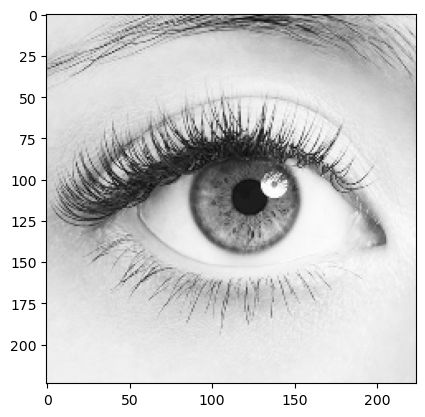

In [12]:
# Predicting an open eye
img_prediction("open_eye_example.jpg")

1/1 [==============================] - 0s 68ms/step
Sigmoid value: 1.1281105e-06
Prediction: Closed


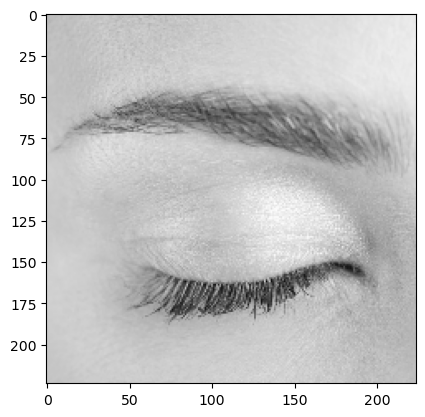

In [13]:
# Predicting a closed eye
img_prediction("closed_eye_example.jpg")

1/1 [==============================] - 0s 111ms/step
Sigmoid value: 0.9996686
Prediction: Open


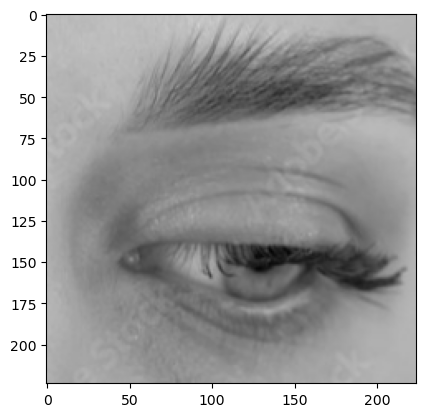

In [14]:
# Predicting a half open eye
img_prediction("half_open_eye_example.jpg")

# Face and Eye Detection

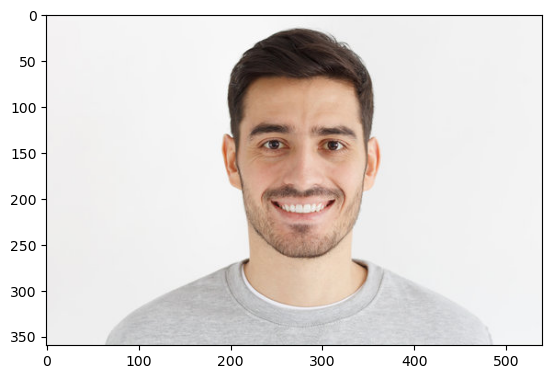

In [15]:
# Importing and displaying new image
img = cv2.imread("face_example.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [16]:
# Face detection
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
face = faceCascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in face:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [19]:
# Eye detection
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in eyes:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), 2)

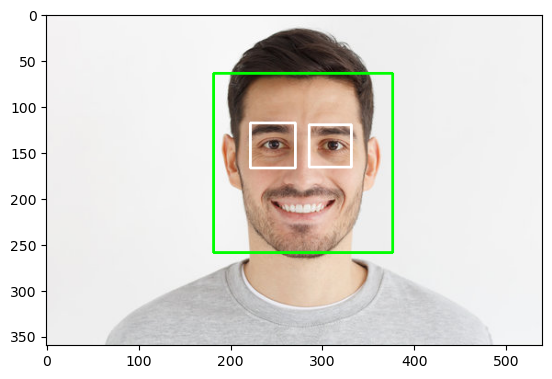

In [20]:
# Showing the result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [21]:
# Cropping the eye images
eye_dict = {}
i = 0
for x, y, w, h in eyes:
    i += 1
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex, ey, ew, eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
                
    eye_dict[i] = eyes_roi

1/1 [==============================] - 0s 64ms/step
Sigmoid value: 1.0
Right eye prediction: Open


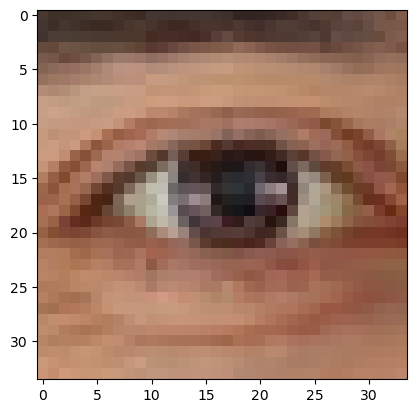

In [22]:
# Transforming the right eye to fit the model
final_image = cv2.resize(eye_dict[1], (img_size, img_size))
final_image = np.expand_dims(final_image, axis = 0) 
final_image = final_image/255

# Giving a prediction
prediction = new_model.predict(final_image)[0][0]
print("Sigmoid value:", prediction)

if prediction > 0.5:
    print("Right eye prediction: Open")
else:
    print("Right eye prediction: Closed")

# Printing the eye
plt.imshow(cv2.cvtColor(eye_dict[1], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 59ms/step
Sigmoid value: 1.0
Left eye prediction: Open


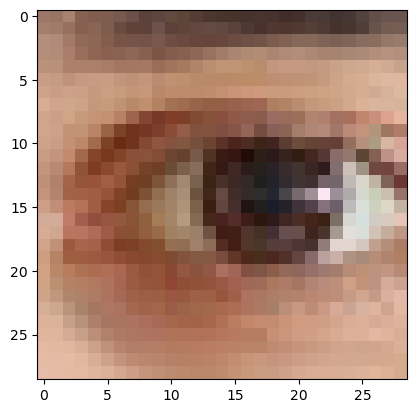

In [26]:
# Transforming the left eye to fit the model
final_image = cv2.resize(eye_dict[2], (img_size, img_size))
final_image = np.expand_dims(final_image, axis = 0) 
final_image = final_image/255

# Giving a prediction
prediction = new_model.predict(final_image)[0][0]
print("Sigmoid value:", prediction)

if prediction > 0.5:
    print("Left eye prediction: Open")
else:
    print("Left eye prediction: Closed")


# Printing the eye
plt.imshow(cv2.cvtColor(eye_dict[2], cv2.COLOR_BGR2RGB))

# Real-time Video Demo

In [29]:
# Importing libraries
import time
from tensorflow.keras import models
from statistics import mean
from pygame import mixer
mixer.init()
mixer.music.load("alarm_audio.mp3")

In [30]:
# Opening camera
cap = cv2.VideoCapture(0)

# Starting with an active status
status = "Open eyes"
color = (0, 255, 0)

# Defining initial variables
count = 0
initial_time = initial_sleep_time = initial_absence_time = time.time()
sleep_check = 5 # in seconds
absence_check = 5 # in seconds
    
while True:
    
    # Capturing image
    ret, frame = cap.read()
    if ret:

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Identifying potencial faces and eyes
        face = faceCascade.detectMultiScale(gray, 1.1, 4)
        eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

        if len(face) != 0 and len(eyes) != 0:

            # Selecting the right face (if more than one face is identified)
            max_face_length = np.amax(face[:, 2:])
            for (fx, fy, fw, fh) in face:
                if fw == max_face_length:

                    # Selecting the right eyes
                    eyes = eyes[eyes[:, 2].argsort()]
                    right_eye = eyes[(fy < eyes[:, 1]) & (eyes[:, 1] < fy+fh/3) & (eyes[:, 1]+eyes[:, 3] < fy+fh) & (eyes[:, 0] > fx) & (eyes[:, 0]+eyes[:, 2] < fx+fw*0.55), :]
                    left_eye = eyes[(fy < eyes[:, 1]) & (eyes[:, 1] < fy+fh/3) & (eyes[:, 1]+eyes[:, 3] < fy+fh) & (eyes[:, 0] > fx+fw*0.45) & (eyes[:, 0]+eyes[:, 2] < fx+fw), :]
                    
                    # Checking if two eyes were detected
                    if (len(right_eye) < 1 or len(left_eye) < 1) and count < 5:
                        count += 1
                        break
                    else:
                        count = 0

                    # Drawing a rectangle around the eyes and making predictions
                    final_predictions = []
                    for (x, y, w, h) in right_eye[:1]:
                        roi_color = frame[y:y + h, x:x + w]
                        cv2.rectangle(frame, (x-2, y-2), (x+w+1, y+h+1), (255, 255, 255), 2)
                        final_image = cv2.resize(roi_color, (224, 224))
                        final_image = np.expand_dims(final_image, axis=0)
                        final_image = final_image / 255
                        final_predictions.append(new_model.predict(final_image)[0][0])
                        
                    for (x, y, w, h) in left_eye[:1]:
                        roi_color = frame[y:y + h, x:x + w]
                        cv2.rectangle(frame, (x-2, y-2), (x+w+1, y+h+1), (255, 255, 255), 2)
                        final_image = cv2.resize(roi_color, (224, 224))
                        final_image = np.expand_dims(final_image, axis=0)
                        final_image = final_image / 255
                        final_predictions.append(new_model.predict(final_image)[0][0])

                    # Checking status
                    if len(final_predictions) != 0:
                        predictions = mean(final_predictions)
                        initial_absence_time = time.time()

                        if predictions > 0.9995:
                            status = "Open eyes"
                            color = (0, 255, 0)   
                            initial_sleep_time = time.time()
                        elif predictions <= 0.9995 and time.time()-initial_sleep_time < sleep_check:
                            status = "Closed eyes"
                            color = (15, 185, 255)
                        else:
                            status = "Unconscious"
                            color = (0, 0, 255)
                            if time.time() > initial_time + 5.1:
                                initial_time = time.time()
                                mixer.music.play()

                    else:
                        status = "Eyes not detected"
                        color = (0, 0, 0)     

                    # Drawing a rectangle around the face
                    cv2.rectangle(frame, (fx, fy), (fx+fw, fy+fh), color, 2)  

                    # Displaying status
                    print(status)
                    cv2.putText(frame, status, (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2, cv2.LINE_4)

                    # Showing frame
                    cv2.imshow("Unconscious detection", frame)
                    if cv2.waitKey(1) & 0xFF == ord("q"):
                        break

                    # Breaking the loop if no one is active
                    if time.time()-initial_absence_time >= absence_check:
                        break

                    break

        else:
            status = "Face not detected"
            color = (0, 0, 0) 

            # Displaying status
            print(status)
            cv2.putText(frame, status, (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2, cv2.LINE_4)

            # Showing frame
            cv2.imshow("Unconscious detection", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

            # Breaking the loop if no one is active
            if time.time()-initial_absence_time >= absence_check:
                break

    else:
        print("Frame not captured")

# Closing camera
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 54ms/step
Open eyes
1/1 [==============================] - 0s 71ms/step
Open eyes
1/1 [==============================] - 0s 55ms/step
Open eyes
1/1 [==============================] - 0s 56ms/step
Open eyes
1/1 [==============================] - 0s 63ms/step
Open eyes
1/1 [==============================] - 0s 56ms/step
Open eyes
1/1 [==============================] - 0s 65ms/step
Open eyes
1/1 [==============================] - 0s 71ms/step
Open eyes
1/1 [==============================] - 0s 63ms/step
Open eyes
1/1 [==============================] - 0s 59ms/step
Open eyes
1/1 [==============================] - 0s 67ms/step
Open eyes
1/1 [==============================] - 0s 61ms/step
Open eyes
1/1 [==============================] - 0s 67ms/step
Open eyes
1/1 [==============================] - 0s 57ms/step
Open eyes
1/1 [==============================] - 0s 66ms/step
Open eyes
1/1 [==============================] - 0s 56ms/step
Closed eyes
1/1 [=

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
